In [237]:
import os

import hydra
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from misc.util import get_bound_fn, points_to_df
from misc.tools import normalize_rows
from game.perception import generate_sim_matrix
from analysis.ib import ib_encoder_to_measurements
from game.game import Game

In [238]:
overrides = [
    "game.num_states=4",
    "game.num_signals=2",
    "game.prior_init_alpha=michael_example",
]

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

# Define a helper which lets us compose new configs since we can't use multirun
def compose(new_overrides):
    """Return a composed hydra config."""
    cfg = hydra.compose(
        config_name="config",
        overrides=overrides + new_overrides,
    )
    return cfg

In [239]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"
multirun_path = os.path.join(root_path, config.filepaths.hydra_sweep_root)

#############################################################################
# Analysis files
#############################################################################

curve_dir = os.path.join(multirun_path, config.filepaths.curve_subdir)
curve_fn = get_bound_fn(config, curve_dir=curve_dir)
mse_curve_fn = get_bound_fn(config, "mse", curve_dir=curve_dir)

In [240]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
curve_data = read(curve_fn)
mse_curve_data = read(mse_curve_fn)

In [241]:
# with prior over states = tensor([0.4000, 0.4000, 0.1000, 0.1000])

# encoders is of shape (num_encoders, meanings, words)
michael_encoders = torch.tensor([
    # encoder 1 is not pareto optimal (?)
    [ 
        [1. , 0.],
        [1. , 0.],
        [0. , 1.],
        [0. , 1.],
    ],
    # encoder 2 is pareto optimal (?),
    [
        [1. , 0.],
        [0. , 1.],
        [1. , 0.],
        [0. , 1.],
    ],
])

In [242]:
# Measure the complexity and accuracy of these encoders
# use ib measurement function and points to df
g = Game.from_hydra(config, cwd = "/Users/nathanielimel/uci/projects/ibsg/multirun/states=4/signals=2/prior=michael_example/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=0/population_size=None/num_runs=8/seed=42/discr_need=1.0")

confusion = normalize_rows(generate_sim_matrix(g.universe, 1, g.dist_mat))
args = [
    g.meaning_dists,
    g.prior,
    g.dist_mat,
    confusion,
]
encoders_points = [
    ib_encoder_to_measurements(*args, michael_encoders[0]),
    ib_encoder_to_measurements(*args, michael_encoders[1]),
]

# some dummy params we need
points_columns = [
    "complexity", 
    "accuracy", 
    "distortion", 
    "mse", 
    ]
efficiency_columns = [
    "gNID", 
    "eps", 
    "beta",
    ]

michael_data = points_to_df(
    [
        (
            *points, # comp, acc, dist, mse,
            None, # gNID computed later
            None, # eps (efficiency loss)
            None, # beta
            f"NE_{i+1}", # run number
        )
    for i, points in enumerate(encoders_points)], 
    columns = points_columns + efficiency_columns + ["example"],
)

In [243]:
g.prior

tensor([0.4000, 0.4000, 0.1000, 0.1000])

In [244]:
michael_data

,complexity,accuracy,distortion,mse,gNID,eps,beta,example
0,0.721928,0.393583,0.228457,0.973912,None,None,None,NE_1
1,1.000000,0.141777,0.480264,1.634977,None,None,None,NE_2


In [245]:
curve_data = curve_data[curve_data["complexity"] > 0]
curve_data

,complexity,accuracy,distortion
20,1.845845e-08,-3.711423e-08,0.622040
21,2.892084e-08,-3.100316e-08,0.622040
22,4.854650e-08,-1.708392e-08,0.622040
23,5.823498e-08,-1.064979e-08,0.622040
24,7.315980e-08,-7.030820e-10,0.622040
...,...,...,...
843,1.652440e+00,6.125499e-01,0.009490
844,1.652707e+00,6.125911e-01,0.009449
845,1.652921e+00,6.126257e-01,0.009415
846,1.653115e+00,6.126576e-01,0.009383


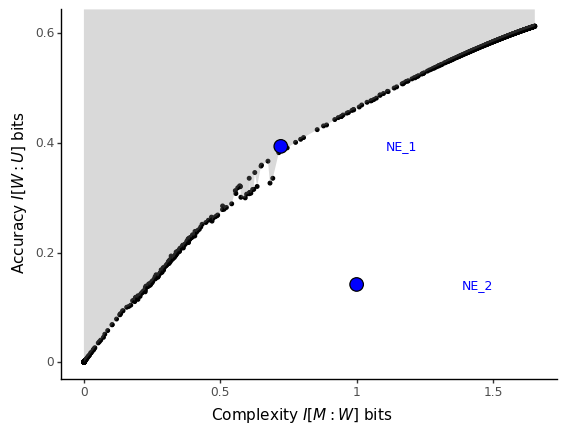

In [246]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    # + pn.geom_line(size=1) # IB curve
    + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # testing langs
        data=michael_data,
        fill="blue",
        size=5,
    )
    + pn.geom_text(
        michael_data,
        pn.aes(label="example"),
        color="blue",
        ha="right",
        size=9,  # orig 9
        nudge_x=.5,
    )
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

In [247]:
mse_curve_data = mse_curve_data[mse_curve_data["complexity"] > 0]
mse_curve_data

,complexity,mse
1,0.000002,2.076583
2,0.000006,1.785688
3,0.000012,1.595479
4,0.000018,1.470054
5,0.000025,1.382985
...,...,...
995,1.721928,0.000000
996,1.721928,0.000000
997,1.721928,0.000000
998,1.721928,0.000000


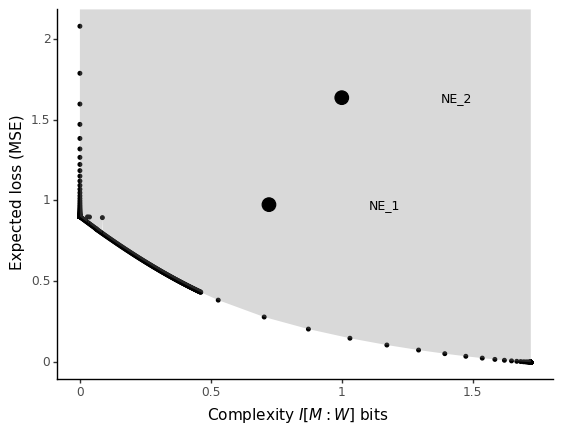

In [248]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=mse_curve_data, mapping=pn.aes(x="complexity", y="mse")
    )  
    # + pn.geom_line(size=1) # IB curve
    + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="mse",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # testing langs
        data=michael_data,
        size=5,
    )
    + pn.geom_text(
        michael_data,
        pn.aes(label="example"),
        ha="right",
        size=9,  # orig 9
        nudge_x=.5,
    )
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Expected loss (MSE)")
    + pn.theme_classic()
)
print(plot)